# In this notebook I will use linear/polynomial regression to predict car's prices.

Data found on kaggle : https://www.kaggle.com/hellbuoy/car-price-prediction

In [1]:
# First let's import libraries used in project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Importing data
data = pd.read_csv('C:/Users/kacpe/Desktop/CarPrice.csv')
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### To make this reggresion easier I will use only a few columns.

In [3]:
data = data[['fueltype', 'doornumber', 'drivewheel', 'cylindernumber', 'enginesize', 'horsepower', 'citympg', 'highwaympg' ,'price']]
data.head()

,fueltype,doornumber,drivewheel,cylindernumber,enginesize,horsepower,citympg,highwaympg,price
0,gas,two,rwd,four,130,111,21,27,13495.0
1,gas,two,rwd,four,130,111,21,27,16500.0
2,gas,two,rwd,six,152,154,19,26,16500.0
3,gas,four,fwd,four,109,102,24,30,13950.0
4,gas,four,4wd,five,136,115,18,22,17450.0


In [4]:
# Checking data types in our dataframe
print(data.dtypes)

fueltype           object
doornumber         object
drivewheel         object
cylindernumber     object
enginesize          int64
horsepower          int64
citympg             int64
highwaympg          int64
price             float64
dtype: object


In [5]:
# Looking for values and their counts in categorical variables.
for i in ['fueltype', 'doornumber', 'drivewheel', 'cylindernumber']:
    print(data[f'{i}'].value_counts(), '\n')

gas       185
diesel     20
Name: fueltype, dtype: int64 

four    115
two      90
Name: doornumber, dtype: int64 

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64 

four      159
six        24
five       11
eight       5
two         4
three       1
twelve      1
Name: cylindernumber, dtype: int64 



In [6]:
# Changing categorical variable into numerical to make dataframe more readable.
data['doornumber'].replace(['two', 'four'], [2,4], inplace= True)
data.head()

,fueltype,doornumber,drivewheel,cylindernumber,enginesize,horsepower,citympg,highwaympg,price
0,gas,2,rwd,four,130,111,21,27,13495.0
1,gas,2,rwd,four,130,111,21,27,16500.0
2,gas,2,rwd,six,152,154,19,26,16500.0
3,gas,4,fwd,four,109,102,24,30,13950.0
4,gas,4,4wd,five,136,115,18,22,17450.0


In [7]:
# Doing the same with cylinder number
data['cylindernumber'].replace(['four', 'six', 'five', 'eight', 'two', 'three', 'twelve'], [4, 6, 5, 8, 2, 3, 12], inplace= True)
data['cylindernumber'].value_counts()

4     159
6      24
5      11
8       5
2       4
3       1
12      1
Name: cylindernumber, dtype: int64

In [8]:
# Converting caregorical variables into dummy variables.
tmp_ftype = pd.get_dummies(data['fueltype'])
tmp_dwheel = pd.get_dummies(data['drivewheel'])
tmp = pd.concat((tmp_dwheel, tmp_ftype), axis= 1)
data.drop(['fueltype', 'drivewheel'], axis= 1, inplace= True)
data = pd.concat((data, tmp), axis= 1)

data.head()

,doornumber,cylindernumber,enginesize,horsepower,citympg,highwaympg,price,4wd,fwd,rwd,diesel,gas
0,2,4,130,111,21,27,13495.0,0,0,1,0,1
1,2,4,130,111,21,27,16500.0,0,0,1,0,1
2,2,6,152,154,19,26,16500.0,0,0,1,0,1
3,4,4,109,102,24,30,13950.0,0,1,0,0,1
4,4,5,136,115,18,22,17450.0,1,0,0,0,1


<AxesSubplot:>

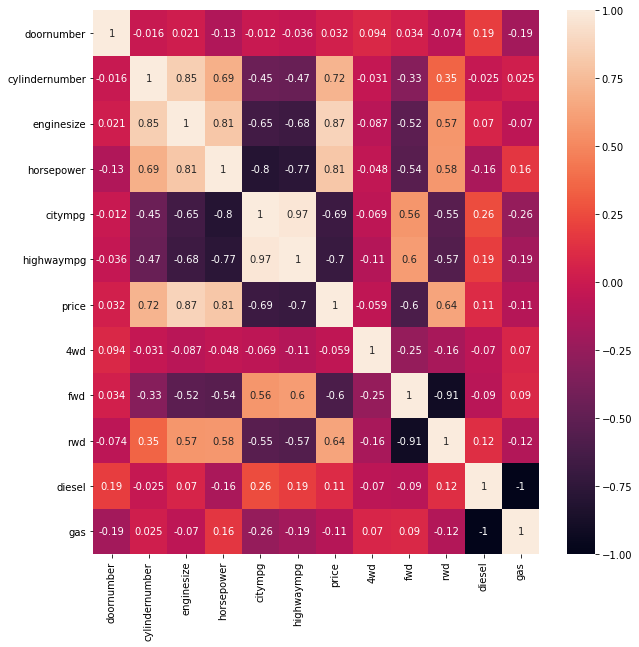

In [9]:
# When our data is ready to use, we can check correlation between variables on heatmap.
plt.figure(figsize = (10, 10))
sns.heatmap(data.corr(), annot = True)

Usually when variables are weak correlated we don't use them in model but for educational purposes I will leave them.  
We can see that price is the most correlated to engine size.

In [10]:
# Creating dependent and independent variables.
X = data.drop('price', axis = 1)
Y = data['price']

print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (205, 11)
Y shape:  (205,)


In [11]:
# Spliting data into trainnig and testing variables.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [12]:
X_train_LR = X_train
X_test_LR = X_test

In [13]:
LR = LinearRegression()

In [14]:
LR.fit(X_train_LR, Y_train)

LinearRegression()

In [15]:
pred = LR.predict(X_test_LR)

print(LR.intercept_)
print(LR.coef_)

1010.6904746245873
[  241.18903971   -47.53973501    91.13480732    50.25003481
   -29.90149402   -90.80679902  -454.72134744 -1173.14279653
  1627.86414397  1615.8114383  -1615.8114383 ]


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
# Checking errors and R squared to validate our model
print("MAE: ", metrics.mean_absolute_error(pred, Y_test))
print("MSE: ", metrics.mean_squared_error(pred, Y_test))
print("R2 Score: ", metrics.r2_score(pred, Y_test))


MAE:  2649.0246871003155
MSE:  13373867.262475833
R2 Score:  0.7214709514903874


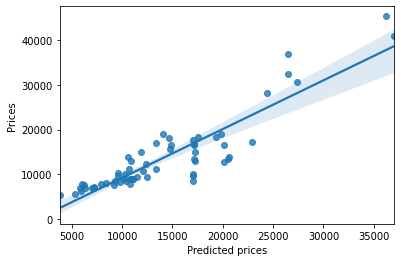

In [18]:
sns.regplot(x = pred, y = Y_test)
plt.xlabel("Predicted prices")
plt.ylabel("Prices")
plt.show()

In [19]:
# Let's check polynomial regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_train_poly

array([[1., 4., 4., ..., 0., 0., 1.],
       [1., 2., 4., ..., 0., 0., 1.],
       [1., 2., 4., ..., 0., 0., 1.],
       ...,
       [1., 4., 5., ..., 1., 0., 0.],
       [1., 4., 4., ..., 0., 0., 1.],
       [1., 4., 5., ..., 0., 0., 1.]])

In [20]:
LR.fit(X_train_poly, Y_train)

LinearRegression()

In [21]:
X_test_poly = poly.transform(X_test)
pred_poly = LR.predict(X_test_poly)

# Model coefficents and intercept
print(LR.intercept_)
print(LR.coef_)

-20453759626897.27
[ 2.04537598e+13 -4.82768288e+01 -6.46226421e+03 -1.02611531e+02
 -6.86630507e+01  3.06357269e+03 -5.14952336e+03  2.22780685e+03
  7.78832523e+03 -1.00161321e+04  6.47595442e+03 -6.47595442e+03
 -2.89660973e+02 -6.35305313e+02  3.52223725e+01  8.33176253e+00
  4.14395656e+00  6.16951197e+00  1.95926431e+03 -4.32708181e+02
 -1.57483296e+03 -6.85422066e+02  6.37145237e+02 -2.82644150e+03
  2.54576127e+02 -9.25472632e+01  1.01416223e+03 -1.48107122e+02
  4.53020545e+03 -6.00942004e+03 -4.98304963e+03 -3.29962678e+03
 -3.16263744e+03 -3.93363447e+00  1.84994744e+00 -3.99106357e+01
  1.85106136e+01 -6.44978199e+02  1.94282662e+02  3.48084006e+02
 -2.51093834e+01 -7.75021481e+01  4.93198868e-01 -2.71641231e+01
  2.92561089e+01  2.72074524e+02 -1.63519882e+02 -1.77217692e+02
 -1.09575126e+02  4.09120752e+01 -2.77772157e+02  3.70238865e+02
  3.99422824e+02  1.39311430e+03  1.27103556e+03  2.18841442e+03
  8.75158272e+02 -7.88727112e+01 -1.42173900e+03 -2.39571088e+03
 -1.33

In [22]:
# Checking errors and R squared
print("MAE: ", metrics.mean_absolute_error(pred_poly, Y_test))
print("MSE: ", metrics.mean_squared_error(pred_poly, Y_test))
print("R2 Score: ", metrics.r2_score(pred_poly, Y_test))


MAE:  2892.2556073588707
MSE:  15532641.07023842
R2 Score:  0.8043250724098576


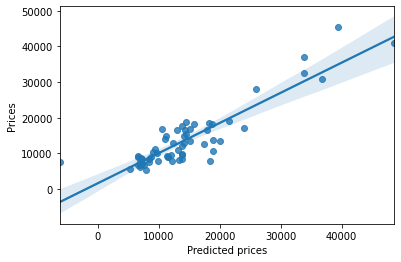

In [23]:
sns.regplot(x = pred_poly, y = Y_test)
plt.xlabel("Predicted prices")
plt.ylabel("Prices")
plt.show()

#### In conclusion we can see that 2nd order polynomial reggresion is explaining 80% of dependent variable by indenendent variables, but has got mean squared error equals to 15 532 641, while linear regression is explaining 72% and has got MSE equal to 13 373 867. 